In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-08-10 23:57:04.872709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 23:57:04.909926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 23:57:04.961854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 23:57:04.962001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11148742935892493593
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6074990592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14547561689989274455
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 23:57:05.422395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 23:57:05.422492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 5793 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [2]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
# load dataset
h5 = h5py.File('./data/NG_stage23_08032022.hdf5', mode='r')
dataset = h5.get('phi')
dataset.shape

(91, 111, 150, 150, 5)

In [3]:
# shuffle dataset
data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

# check dataset size
print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Dataset shape is: (91, 111, 150, 150, 5)
Splitted trainning dataset shape is: (68, 111, 150, 150, 5)
Splitted trainning dataset shape is: (23, 111, 150, 150, 5)


In [4]:
from tqdm import tqdm

def create_shifted_frames_many2one(dataset,numFrames):
    sz = dataset.shape[0]*(dataset.shape[1]-numFrames)
    x = np.zeros([sz, numFrames, dataset.shape[2],dataset.shape[3], 5])
    y = np.zeros([sz, 2, dataset.shape[2],dataset.shape[3], 5])
    k = 0
    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
            x[k,...] = pastFrames
            y[k,0,...] = currentFrame
            y[k,1,...] = pastFrames[:,-1,...] # passing past frame to ground truth for use in loss function (an issue with directly passing inp into loss func)
            k+=1  
    return x,y

# creatign many to 1 shifted trainning and validation dataset
numFrames = 5
x_train, y_train = create_shifted_frames_many2one(train_dataset,numFrames)
x_val, y_val = create_shifted_frames_many2one(val_dataset,numFrames)

# increase tubulin magnitude (actual value too small)
x_train[...,2] = x_train[...,2]
y_train[...,2] = y_train[...,2]
x_val[...,2] = x_val[...,2]
y_val[...,2] = y_val[...,2]

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Running ...: 100%|██████████| 23/23 [00:07<00:00,  3.17it/s]


Training Dataset Shapes: (7208, 5, 150, 150, 5), (7208, 2, 150, 150, 5)
Validation Dataset Shapes: (2438, 5, 150, 150, 5), (2438, 2, 150, 150, 5)


In [5]:
# def rm_zeroTips_bothXY(input,input1):
#     ind = []
#     for i in range(input.shape[0]):
#         for j in range(input.shape[1]):
#             if np.amax(input[i,j,:,:,1])==0:
#                 ind.append(i)

#     ind = np.unique(ind)
#     print(f"Deleting {len(ind)} scenarios with empty tips")

#     try:
#         output = np.delete(input,ind,axis=0)
#         output1 = np.delete(input1,ind,axis=0)
#     except:
#         output = input
#         output1 = input1

#     return output, output1

# x_train = rm_zeroTips_bothXY(x_train,y_train)
# y_train = rm_zeroTips_bothXY(y_train,x_train)
# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# x_val = rm_zeroTips_bothXY(x_val,y_val)
# y_val = rm_zeroTips_bothXY(y_val,x_val)
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

In [6]:
# function to calculate partial derivatives of the input
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

# calculate MSE
def get_MSE_tf(input,goal):
    return tf.math.reduce_mean(tf.square(tf.math.subtract(input, goal)))

def get_MAE_tf(input,goal):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(input-goal)))

def get_MRE_tf(input,goal):
    return tf.math.divide(get_MAE_tf(input,goal),(tf.math.reduce_max(goal)-tf.math.reduce_min(goal)))
    
# PINN - physics-informed loss function for Phase-field neuron growth model
def PINN_loss():
    def loss(y_true, y_pred):
        dt = 0.01*500 # current data sampled per 500 iter (change based on dataset)
        # y_true = tf.cast(y_true, dtype=tf.float64)
        # y_pred = tf.cast(y_pred, dtype=tf.float64)

        # # extract variables from ground truth
        true_phi = tf.expand_dims(y_true[:,0,:,:,0],axis=3)
        true_tips = tf.expand_dims(y_true[:,0,:,:,1],axis=3)
        true_tub = tf.expand_dims(y_true[:,0,:,:,2],axis=3)
        true_tempr = tf.expand_dims(y_true[:,0,:,:,3],axis=3)
        theta = tf.expand_dims(y_true[:,0,:,:,4],axis=3) # Since theta is passed, theta remains the same
        # # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        # NN_p = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
        # tips_p = tf.expand_dims(inp[:,-1,:,:,1],axis=3)
        # tub_p = tf.expand_dims(inp[:,-1,:,:,2],axis=3)
        # tempr_p = tf.expand_dims(inp[:,-1,:,:,3],axis=3)
        # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        NN_p = tf.expand_dims(y_true[:,1,:,:,0],axis=3)
        tips_p = tf.expand_dims(y_true[:,1,:,:,1],axis=3)
        tub_p = tf.expand_dims(y_true[:,1,:,:,2],axis=3)
        tempr_p = tf.expand_dims(y_true[:,1,:,:,3],axis=3)
        # extract variables from prediction
        NN_pK = tf.expand_dims(y_pred[:,-1,:,:,0],axis=3)
        tips_pK = tf.expand_dims(y_pred[:,-1,:,:,1],axis=3)
        tub_pK = tf.expand_dims(y_pred[:,-1,:,:,2],axis=3)
        tempr_pK = tf.expand_dims(y_pred[:,-1,:,:,3],axis=3)

        # calc corresponding partial derivatives
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_p)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_p)

        # Temperature residual
        tempr_residual = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_p - tempr_pK

        # Tubulin residual
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_p) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_p) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_p)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_residual = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_p - tub_pK

        # phase field residual
        e = 0.2865*tf.math.atan(10*tf.math.multiply(tf.math.multiply(tips_p,5*tub_pK-0.1),1-tempr_pK)) # energy equation
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + e + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

        # calculate mean of each residual and mse of prediction and ground truth
        residual_mse = tf.math.reduce_mean(phi_residual) + tf.math.reduce_mean(tempr_residual) + tf.math.reduce_mean(tub_residual)
        # mae = tf.keras.losses.mean_absolute_error()

        diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MSE_tf(tips_pK,true_tips) + get_MRE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        # diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MRE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        # 
        return tf.math.abs(residual_mse) + tf.math.abs(diff_mse)
        # return tf.math.abs(diff_mse)
        # return tf.math.reduce_max(inp)
    return loss

In [13]:
import copy
# start matlab engine, requires valid installation of matlab and matlab.engine library
import matlab.engine
eng = matlab.engine.start_matlab()
s = eng.genpath('Matlab_algorithm')
eng.addpath(s, nargout=0)

# calc mre between pred and goal
def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output

model = keras.models.load_model('./saved_model/model_conv_lstm_test_43', custom_objects={'loss': PINN_loss()})

from tqdm import tqdm
x_train_pred_phi = np.zeros([x_train.shape[0],x_train.shape[2],x_train.shape[3],2])
jj = 0
for rand_case in tqdm(range(x_train.shape[0]), desc="Generating phi prediction from x_train ..."):
    x_in = np.expand_dims(x_train[rand_case,...],axis=0)
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    x_train_pred_phi[jj,:,:,0] = new_prediction[0,0,:,:,0]
    x_train_pred_phi[jj,:,:,1] = new_prediction[0,0,:,:,-1]
    jj+=1
x_train_pred_phi = np.delete(x_train_pred_phi,0,axis=0)

y_train_phi = np.expand_dims(y_train[:,0,:,:,0],axis=3)
y_train_tips = np.expand_dims(y_train[:,0,:,:,1],axis=3)
y_train_tips = np.delete(y_train_tips,-1,axis=0)
# y_train_tips = y_train_phi-np.expand_dims(x_train_pred_phi[:,:,:,0],axis=3)
y_train_tips[y_train_tips!=0] = 1

print("Training Dataset Shapes: " + str(x_train_pred_phi.shape) + ", Target Tips Shape:" + str(y_train_tips.shape) + ", Target Phi Shapes:" + str(y_train_phi.shape))

Generating phi prediction from x_train ...: 100%|██████████| 7208/7208 [04:38<00:00, 25.86it/s]


Training Dataset Shapes: (7207, 150, 150, 2), Target Tips Shape:(7207, 150, 150, 1), Target Phi Shapes:(7208, 150, 150, 1)


Rand case: 6


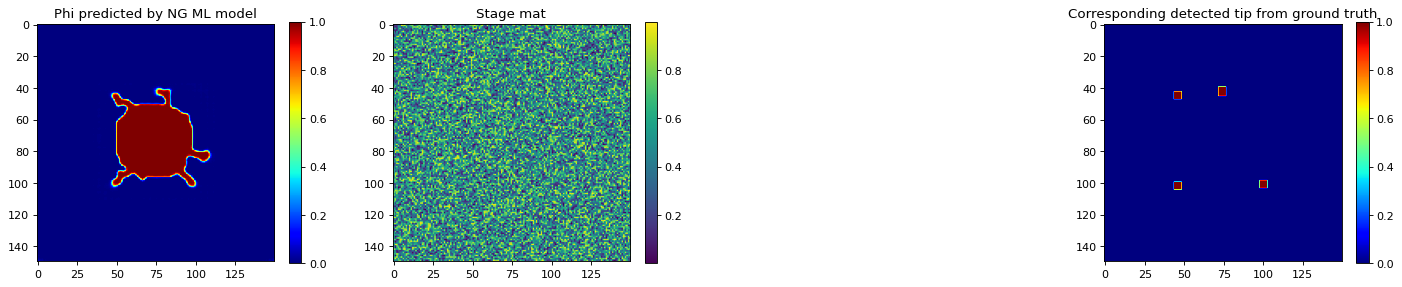

In [8]:
rand_case = np.random.randint((len(val_dataset)))
print(f"Rand case: {rand_case}")
plt.figure(figsize=(22, 4), dpi=80)

plt.subplot(1,4,1)
plt.imshow(x_train_pred_phi[rand_case,...,0],cmap='jet')
plt.colorbar()
plt.title('Phi predicted by NG ML model')
plt.subplot(1,4,2)
plt.imshow(x_train_pred_phi[rand_case,...,1])
plt.colorbar()
plt.title('Corresponding theta from ground truth')
# plt.subplot(1,4,3)
# plt.imshow(x_train_pred_phi[rand_case,...,2],cmap='jet')
# plt.colorbar()
plt.title('Stage mat')
plt.subplot(1,4,4)
plt.imshow(y_train_tips[rand_case,...],cmap='jet')
plt.colorbar()
plt.title('Corresponding detected tip from ground truth')
plt.show()

In [9]:
x_val_pred_phi = np.zeros([x_val.shape[0],x_val.shape[2],x_val.shape[3],2])
jj = 0
for rand_case in tqdm(range(x_val.shape[0]), desc="Generating phi prediction from x_val ..."):
    x_in = np.expand_dims(x_val[rand_case,...],axis=0)
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    x_val_pred_phi[jj,:,:,0] = new_prediction[0,0,:,:,0]
    x_val_pred_phi[jj,:,:,1] = new_prediction[0,0,:,:,-1]
    jj+=1

y_val_phi = np.expand_dims(y_val[:,0,:,:,0],axis=3)
y_val_tips = np.expand_dims(y_val[:,0,:,:,1],axis=3)
# y_val_tips = y_val_phi-np.expand_dims(x_val_pred_phi[:,:,:,0],axis=3)
y_val_tips[y_val_tips!=0] = 1

print("Training Dataset Shapes: " + str(x_val_pred_phi.shape) + ", Target Tips Shape:" + str(y_val_tips.shape) + ", Target Phi Shapes:" + str(y_val_phi.shape))

Generating phi prediction from x_val ...: 100%|██████████| 2438/2438 [01:41<00:00, 24.00it/s]


Training Dataset Shapes: (2438, 150, 150, 2), Target Tips Shape:(2438, 150, 150, 1), Target Phi Shapes:(2438, 150, 150, 1)


Rand case: 7


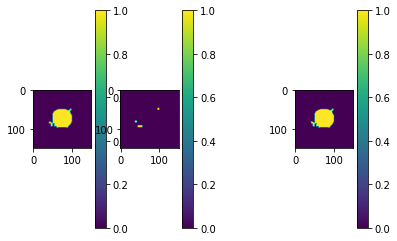

In [10]:
rand_case = np.random.randint((len(val_dataset)))
print(f"Rand case: {rand_case}")
plt.subplot(1,4,1)
plt.imshow(x_val_pred_phi[rand_case,...,0])
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(y_val_tips[rand_case,...])
plt.colorbar()
# plt.subplot(1,4,3)
# plt.imshow(x_val_pred_phi[rand_case,...,1])
# plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(y_val_phi[rand_case,...])
plt.colorbar()
plt.show()

In [11]:
np.save("data/tips/x_train_pred_phi_0810.npy",x_train_pred_phi)
np.save("data/tips/x_val_pred_phi_0810.npy",x_val_pred_phi)
np.save("data/tips/y_train_phi_0810.npy",y_train_phi)
np.save("data/tips/y_train_tips_0810.npy",y_train_tips)
np.save("data/tips/y_val_phi_0810.npy",y_val_phi)
np.save("data/tips/y_val_tips_0810.npy",y_val_tips)

In [12]:
x_train_pred_phi.shape

(7208, 150, 150, 2)